# Toxic Comment Classification

### Text Classification Project by _Hye Joo Han_

### Overview of this project
1. <a href='#Section1'>Data Description</a>
2. <a href='#Section2'>Project Goal</a>
3. <a href='#Section3'>Brief EDA</a>
4. <a href='#Section4'>Cleaning and Stemming</a>
5. <a href='#Section5'>TfidfVectorizer</a>
6. <a href='#Section6'>Logistic Regression</a>
7. <a href='#Section7'>More tuning</a>
8. <a href='#Section8'>Summary so far</a>
9. <a href='#Section9'>Furture Directions</a>
 
_Please note that this project has not been completed, but there is <a href='#Section8'>Summary so far</a> at the end of notebook._

<a id= 'Section1'></a>
## 1. Data Description
- Data sets train.csv and test.csv were downloaded from a Kaggle Competition (by Jigsaw and Google) https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge 
- train.csv is the training set that contains comments with their id and 6 binary labels. 
- test.csv is the test set that contains comments and their id only. I have to predict the labels, toxicity probabilities.
- The training set includes 8 columns: 
   - id (comment id number)
   - comment_text (Wikipedia comments. Each comment was labeled by human raters for  6 types of toxic behaviors. The following 6 columns are the rated labels) 
   - toxic
   - severe_toxic
   - obscene 
   - threat
   - insult
   - identity_hate 
- Note that the 6 categories are not mutually exclusive.

<a id= 'Section2'></a>
## 2. Project Goal
Find an algorithm or create a model that predicts a probability of each type of toxicity for each comment the best.

<a id= 'Section3'></a>
## 3. Brief EDA

I will do some brief exploratory data analysis using the training set.

In [46]:
# import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
import string
import re

In [47]:
train = pd.read_csv('train.csv') #training set
test = pd.read_csv('test.csv') #test set

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [49]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [50]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The count shows there are _159,571_ comments. The mean shows the proportions of toxic comments for each category:
  - Toxic:         9.58% 
  - Severe Toxic:  1.00%
  - Obcene:        5.29%
  - Threat:        0.30%
  - Insult:        4.94%
  - Identity hate: 0.88%
  
The proportions show this data set has very unblanced classes for each category of toxic behavior. Some of the categories like Threat (.30%), Indentity hate (.88%), and Severe Toxic (1.00%) are severely unbalanced. Thus, the validation methods such as train/test split or performance metrics should be carefully selected.

There seems to be no missing values. I will confirmed this in the next cell.

In [51]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [52]:
# Count the number of comments with only white spaces
empty_comment = 0 
for comment in train['comment_text']:
    if re.match('\s+', comment):
        empty_comment +=1
empty_comment

0

I also checked if there is any blank comment, but I found none.

In [53]:
# Check some real comments
for i in range(3):
    print("Sample comment {}".format(i),'\n', train['comment_text'][i])

Sample comment 0 
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Sample comment 1 
 D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Sample comment 2 
 Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.


It seems there are sometimes IP addresses or dates and times. CLeaning them might improve my predictions, but I will keep them there for now.

In [54]:
# check the length of each comment
lengths = np.vectorize(len)
text_len = lengths(train['comment_text'])

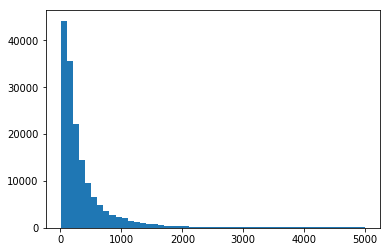

In [56]:
plt.hist(text_len, bins = 50)
plt.show()

In [55]:
print("Minimum text length: ", min(text_len), "characters")
print("Maximum text length: ", max(text_len), "characters")

Minimum text length:  6 characters
Maximum text length:  5000 characters


The comment length ranges from 6 to 5000 characters and its distribution is highly right-skewed. I wonder whether comment lengths are related to the probability of toxicity.

In [59]:
# Check outliers? Try a box plot and check the longest comment.

<a id='Section4'></a>
## 4. Cleaning and Stemming

Here I will clean text comments and apply stemming.

In [57]:
# Get pandas series out of data frames 
train_comment = train['comment_text']
test_comment = test['comment_text']

### Trying out with one comment

To develope each step, I will first use only one comment and then apply all steps to all comments. 

In [60]:
sample_comment = train['comment_text'][0]
print(sample_comment)

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [61]:
# remove punctuations
sample_comment = re.sub(r'[^\w\s]','',sample_comment)
print(sample_comment)

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted They werent vandalisms just closure on some GAs after I voted at New York Dolls FAC And please dont remove the template from the talk page since Im retired now892053827


In [62]:
# split text into words
word_list = sample_comment.split()
print(word_list)

['Explanation', 'Why', 'the', 'edits', 'made', 'under', 'my', 'username', 'Hardcore', 'Metallica', 'Fan', 'were', 'reverted', 'They', 'werent', 'vandalisms', 'just', 'closure', 'on', 'some', 'GAs', 'after', 'I', 'voted', 'at', 'New', 'York', 'Dolls', 'FAC', 'And', 'please', 'dont', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'Im', 'retired', 'now892053827']


In [63]:
# apply stemmer and combine them again
stemmer= SnowballStemmer("english")

words = ""
for word in word_list:
    if word != "":
        word_stemmed = stemmer.stem(word)
        words += word_stemmed + " "
print(words)

explan whi the edit made under my usernam hardcor metallica fan were revert they werent vandal just closur on some gas after i vote at new york doll fac and pleas dont remov the templat from the talk page sinc im retir now892053827 


### Apply all steps to every comment

Now it' time to apply the above steps to every comment in the training set. First, I will make a function that combines all the steps.

In [64]:
def text_preprocessing(text):
    #remove punctuations
    text_string = re.sub(r'[^\w\s]','',text)
    #split text into words
    word_list = text_string.split()
    #apply stemmer and combine them again
    stemmer= SnowballStemmer("english")
    words = ""
    for word in word_list:
        if word != "":
            word_stemmed = stemmer.stem(word)
            words += word_stemmed + " "
    return words

In [66]:
print("Original text:","\n", train['comment_text'][0])
print()
print("Processed text:","\n", text_preprocessing( train['comment_text'][0]))

Original text: 
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Processed text: 
 explan whi the edit made under my usernam hardcor metallica fan were revert they werent vandal just closur on some gas after i vote at new york doll fac and pleas dont remov the templat from the talk page sinc im retir now892053827 


Great! The function works well for one text. Now it's time to apply the preprocessing function to all comments in the training set.

In [67]:
#Check original comments in the training set
train_comment.head(10)

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
5    "\n\nCongratulations from me as well, use the ...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [68]:
%%time
# stemming all comments in the training set
train_comment_stemmed = train_comment.apply(text_preprocessing)

Wall time: 2min 25s


In [70]:
train_comment_stemmed.head(10)

0    explan whi the edit made under my usernam hard...
1    daww he match this background colour im seem s...
2    hey man im realli not tri to edit war it just ...
3    more i cant make ani real suggest on improv i ...
4    you sir are my hero ani chanc you rememb what ...
5    congratul from me as well use the tool well talk 
6           cocksuck befor you piss around on my work 
7    your vandal to the matt shirvington articl has...
8    sorri if the word nonsens was offens to you an...
9    align on this subject and which are contrari t...
Name: comment_text, dtype: object

The texts in the test set should be also stemmed since words in the test set should be vectorized and transformed into a feature matrix as well.

In [71]:
%%time
# stemming all comments in the test set
test_comment_stemmed = test_comment.apply(text_preprocessing)

Wall time: 2min 1s


In [123]:
test_comment_stemmed.head()

0    yo bitch ja rule is more succes then youll eve...
1              from rfc the titl is fine as it is imo 
2                         sourc zaw ashton on lapland 
3    if you have a look back at the sourc the infor...
4                    i dont anonym edit articl at all 
Name: comment_text, dtype: object

Done with cleaning and stemming! Now let's move on to the vectorization part.

<a id='Section5'></a>
## 5. TfidfVectorizer
A vectorizer converts a collection of text documents into a numerical (sparse) matrix with 1 row per document and 1 column per token (e.g. word). I will use the Tf-idf (term frequency inverse document frequency) vectorizer.

In [90]:
%%time
# Using stemmed comments
vectorizer = TfidfVectorizer(analyzer ='word', 
                             stop_words='english',
                             sublinear_tf=True, #term-freq scaling
                             strip_accents='unicode', #works generally
                             token_pattern=r'\w{1,}', #1+ char words
                             ngram_range=(1,1),
                             max_features=10000) #consider top 10000

vectorizer.fit(pd.concat([train_comment_stemmed,test_comment_stemmed]))

train_feature_matrix = vectorizer.transform(train_comment_stemmed)
#test_feature_matrix = vectorizer.transform(test_comment_stemmed)

Wall time: 34.8 s


'token_pattern' and 'ngram_range' will be tuned later.

In [91]:
# this function will help checking the results at glance
def print_results():
    print("### Tuning hyper-parameters for {} ###".format(category))
    print()
    print("Best hyper-parameters on development set:")
    print(clf.best_params_)
    print()
    print("Grid search scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.4f (+/-%0.04f) for %r" % (mean, std * 2, params))
    print()    

<a id='Section6'></a>
## 6. Logistic Regression

Logistic regression will be test as a classifier. I will tune some hyper-parameters, but more fine tuning will be done in the next section.

#### Performance measure
The performance measure selected is 'roc_auc' since the Kaggle competition uses the metric for evaluation. I do not believe AUC is a good measure for data with highky unbalanced classes, but the only way to evaluate my model using the test set is submitting my predictions to the leaderboard, which will let me know only AUC values. Note that high AUC scores (e.g., 0.98) from unbalanced data do not mean your model is actually predicting well. F1 or other scores could be still very bad!!! For this reason, I will check some other performance measures as well.   

#### C
The hyper-parameter 'C' for LogisticRegression represents the inverse of regularization strength. I will use "coarse to fine" strategy to tune C and optimize C value for each type of toxicity.

#### Solver
If 'C'=100 is included in the hyper-parameter set, 'sag' gives bunch of convergence warnings, takes so much longer and the score for 'C'=100 was worse than lower C. Thus, I omitted 100 from the 'C' range. 

In [92]:
train.columns # just to coveniently copy and paste category names below

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [93]:
categories =['toxic', 'severe_toxic', 'obscene', 
             'threat', 'insult', 'identity_hate']

In [105]:
%%time
for category in categories:
    train_labels = train[category]
    parameters = {'solver':['liblinear', 'sag'],'C': [.1,1,10]}
    log_reg = LogisticRegression()   
    clf= GridSearchCV(log_reg, parameters, scoring='roc_auc', cv=3)
    clf.fit(train_feature_matrix, train_labels)
    print_results()

### Tuning hyper-parameters for toxic ###

Best hyper-parameters on development set:
{'C': 1, 'solver': 'sag'}

Grid search scores on development set:
0.9595 (+/-0.0048) for {'C': 0.1, 'solver': 'liblinear'}
0.9596 (+/-0.0048) for {'C': 0.1, 'solver': 'sag'}
0.9696 (+/-0.0028) for {'C': 1, 'solver': 'liblinear'}
0.9696 (+/-0.0028) for {'C': 1, 'solver': 'sag'}
0.9656 (+/-0.0022) for {'C': 10, 'solver': 'liblinear'}
0.9656 (+/-0.0022) for {'C': 10, 'solver': 'sag'}

### Tuning hyper-parameters for severe_toxic ###

Best hyper-parameters on development set:
{'C': 1, 'solver': 'sag'}

Grid search scores on development set:
0.9837 (+/-0.0029) for {'C': 0.1, 'solver': 'liblinear'}
0.9839 (+/-0.0025) for {'C': 0.1, 'solver': 'sag'}
0.9851 (+/-0.0033) for {'C': 1, 'solver': 'liblinear'}
0.9851 (+/-0.0032) for {'C': 1, 'solver': 'sag'}
0.9790 (+/-0.0049) for {'C': 10, 'solver': 'liblinear'}
0.9790 (+/-0.0049) for {'C': 10, 'solver': 'sag'}

### Tuning hyper-parameters for obscene ###

Best hyp

I found that 1 is the best inverse regularization level 'C' among .1, 1, and 10, but the more fine turning for C will be performed in the next section.   

The 'sag' solver performs slighly better than 'liblinear' except for Threat category. Since the difference between the two solvers for Threat is less than .0001 (when C is optimized), I will just use 'sag' for all categories. 

<a id="Section7"></a>
## 7. More Tuning

I will fist do some tuning for C. 

In [106]:
%%time
for category in categories:
    train_labels = train[category]
    parameters = {'C': [.2, .5, 1, 2, 5]}
    log_reg = LogisticRegression(solver = 'sag')   
    clf= GridSearchCV(log_reg, parameters, scoring='roc_auc', cv=3)
    clf.fit(train_feature_matrix, train_labels)
    print_results()

### Tuning hyper-parameters for toxic ###

Best hyper-parameters on development set:
{'C': 2}

Grid search scores on development set:
0.9640 (+/-0.0041) for {'C': 0.2}
0.9681 (+/-0.0033) for {'C': 0.5}
0.9696 (+/-0.0028) for {'C': 1}
0.9698 (+/-0.0025) for {'C': 2}
0.9682 (+/-0.0022) for {'C': 5}

### Tuning hyper-parameters for severe_toxic ###

Best hyper-parameters on development set:
{'C': 0.5}

Grid search scores on development set:
0.9846 (+/-0.0026) for {'C': 0.2}
0.9852 (+/-0.0028) for {'C': 0.5}
0.9851 (+/-0.0032) for {'C': 1}
0.9844 (+/-0.0037) for {'C': 2}
0.9821 (+/-0.0044) for {'C': 5}

### Tuning hyper-parameters for obscene ###

Best hyper-parameters on development set:
{'C': 1}

Grid search scores on development set:
0.9818 (+/-0.0037) for {'C': 0.2}
0.9836 (+/-0.0034) for {'C': 0.5}
0.9843 (+/-0.0032) for {'C': 1}
0.9841 (+/-0.0031) for {'C': 2}
0.9823 (+/-0.0028) for {'C': 5}

### Tuning hyper-parameters for threat ###

Best hyper-parameters on development set:
{'C': 

I found the better opimized C for each category, but C will be tuned even more after finding the best vectorizer.

### Tuning parameters for vectorizer

For the previous vectorizer, I used token_pattern=r'\w{1,}' to consider 1+ alphanumeric character words as a token and ngram_range=(1,1). In this section, I will try token_pattern=r'\w{2,}' to consider 2+ alphanumeric character words as a token and ngram_range=(1,2) to consider bigrams together with unigrams.

In [107]:
#try ngram_range=(1,2) instead of (1,1) to take bigrams into account
vectorizer = TfidfVectorizer(analyzer ='word', 
                             stop_words='english',
                             sublinear_tf=True, #term-freq scaling
                             strip_accents='unicode', #works generally
                             token_pattern=r'\w{1,}', #1+ char words
                             ngram_range=(1,2),
                             max_features=10000) #consider top 10000
vectorizer.fit(pd.concat([train_comment_stemmed,test_comment_stemmed]))
train_feature_matrix = vectorizer.transform(train_comment_stemmed)

In [109]:
%%time
for category in categories:
    train_labels = train[category]
    parameters = {'C':  [.2, .5, 1, 2, 5]}
    log_reg = LogisticRegression(solver = 'sag')   
    clf= GridSearchCV(log_reg, parameters, scoring='roc_auc', cv=3)
    clf.fit(train_feature_matrix, train_labels)
    print_results()

### Tuning hyper-parameters for toxic ###

Best hyper-parameters on development set:
{'C': 1}

Grid search scores on development set:
0.9631 (+/-0.0044) for {'C': 0.2}
0.9669 (+/-0.0036) for {'C': 0.5}
0.9681 (+/-0.0031) for {'C': 1}
0.9679 (+/-0.0028) for {'C': 2}
0.9654 (+/-0.0027) for {'C': 5}

### Tuning hyper-parameters for severe_toxic ###

Best hyper-parameters on development set:
{'C': 0.5}

Grid search scores on development set:
0.9840 (+/-0.0031) for {'C': 0.2}
0.9845 (+/-0.0035) for {'C': 0.5}
0.9843 (+/-0.0040) for {'C': 1}
0.9834 (+/-0.0047) for {'C': 2}
0.9807 (+/-0.0057) for {'C': 5}

### Tuning hyper-parameters for obscene ###

Best hyper-parameters on development set:
{'C': 1}

Grid search scores on development set:
0.9813 (+/-0.0036) for {'C': 0.2}
0.9831 (+/-0.0034) for {'C': 0.5}
0.9835 (+/-0.0032) for {'C': 1}
0.9831 (+/-0.0031) for {'C': 2}
0.9807 (+/-0.0027) for {'C': 5}

### Tuning hyper-parameters for threat ###

Best hyper-parameters on development set:
{'C': 

Considering bigrams made the performance worse. Now I will try the different token_pattern while keeping ngram_range=(1,1).

In [110]:
%%time
#try token_pattern=r'\w{2,}' instead of r'\w{1,}'
vectorizer = TfidfVectorizer(analyzer ='word', 
                             stop_words='english',
                             sublinear_tf=True, #term-freq scaling
                             strip_accents='unicode', #works generally
                             token_pattern=r'\w{2,}', #2+ char words
                             ngram_range=(1,1),
                             max_features=10000) #consider top 10000
vectorizer.fit(pd.concat([train_comment_stemmed,test_comment_stemmed]))
train_feature_matrix = vectorizer.transform(train_comment_stemmed)

for category in categories:
    train_labels = train[category]
    parameters = {'C': [.2, .5, 1, 2, 5]}
    log_reg = LogisticRegression(solver = 'sag')   
    clf= GridSearchCV(log_reg, parameters, scoring='roc_auc', cv=3)
    clf.fit(train_feature_matrix, train_labels)
    print_results()

### Tuning hyper-parameters for toxic ###

Best hyper-parameters on development set:
{'C': 2}

Grid search scores on development set:
0.9637 (+/-0.0042) for {'C': 0.2}
0.9677 (+/-0.0034) for {'C': 0.5}
0.9692 (+/-0.0028) for {'C': 1}
0.9695 (+/-0.0025) for {'C': 2}
0.9678 (+/-0.0022) for {'C': 5}

### Tuning hyper-parameters for severe_toxic ###

Best hyper-parameters on development set:
{'C': 0.5}

Grid search scores on development set:
0.9843 (+/-0.0023) for {'C': 0.2}
0.9847 (+/-0.0024) for {'C': 0.5}
0.9845 (+/-0.0027) for {'C': 1}
0.9836 (+/-0.0032) for {'C': 2}
0.9811 (+/-0.0037) for {'C': 5}

### Tuning hyper-parameters for obscene ###

Best hyper-parameters on development set:
{'C': 1}

Grid search scores on development set:
0.9814 (+/-0.0038) for {'C': 0.2}
0.9832 (+/-0.0036) for {'C': 0.5}
0.9838 (+/-0.0034) for {'C': 1}
0.9836 (+/-0.0032) for {'C': 2}
0.9817 (+/-0.0030) for {'C': 5}

### Tuning hyper-parameters for threat ###

Best hyper-parameters on development set:
{'C': 

Changing token_pattern to 2+ alphanumeric charaters also made predictions worse. I expect taht changing both taken_pattern and ngram_range would not imrove the performance, I will keep the original parameters used in the previous section.

I am done with tuning the vectorizer, so I will go back to tuning C for LogisticRegression.

### Fine tuning for C

In [124]:
%%time
vectorizer = TfidfVectorizer(analyzer ='word', 
                             stop_words='english',
                             sublinear_tf=True, #term-freq scaling
                             strip_accents='unicode', #works generally
                             token_pattern=r'\w{1,}', #1+ char words
                             ngram_range=(1,1),
                             max_features=10000) #consider top 10000

vectorizer.fit(pd.concat([train_comment_stemmed,test_comment_stemmed]))

train_feature_matrix = vectorizer.transform(train_comment_stemmed)
test_feature_matrix = vectorizer.transform(test_comment_stemmed) # finally we need this line

Wall time: 34.6 s


The optimized C in the previous section was 2, .5, 1, 2, 1, 1 for 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', respectively. Thus, I will do fine tuning around the best C of each category.

In [117]:
%%time
# Tune C for each category CV=100 
parameters_dic={'toxic':{'C':[1.1,1.2,1.3,1.4,1.5, 1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5]},
                'severe_toxic':{'C':[.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]},
                'obscene':{'C':[.6,.7,.8,.9,1.0,1.1,1.2,1.3,1.4,1.5]},
                'threat':{'C':[1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5]}, 
                'insult':{'C':[.6,.7,.8,.9,1.0,1.1,1.2,1.3,1.4,1.5]}, 
                'identity_hate':{'C':[.6,.7,.8,.9,1.0,1.1,1.2,1.3,1.4,1.5]}}
for category in categories:
    train_labels = train[category]
    parameters = parameters_dic[category]
    log_reg = LogisticRegression(solver='sag')   
    clf= GridSearchCV(log_reg, parameters, scoring='roc_auc', cv=100)
    clf.fit(train_feature_matrix, train_labels)
    print_results()

### Tuning hyper-parameters for toxic ###

Best hyper-parameters on development set:
{'C': 1.4}

Grid search scores on development set:
0.9713 (+/-0.0117) for {'C': 1.1}
0.9713 (+/-0.0117) for {'C': 1.2}
0.9714 (+/-0.0116) for {'C': 1.3}
0.9714 (+/-0.0116) for {'C': 1.4}
0.9714 (+/-0.0116) for {'C': 1.5}
0.9714 (+/-0.0116) for {'C': 1.6}
0.9713 (+/-0.0116) for {'C': 1.7}
0.9713 (+/-0.0116) for {'C': 1.8}
0.9713 (+/-0.0116) for {'C': 1.9}
0.9712 (+/-0.0116) for {'C': 2.0}
0.9712 (+/-0.0116) for {'C': 2.1}
0.9712 (+/-0.0116) for {'C': 2.2}
0.9711 (+/-0.0116) for {'C': 2.3}
0.9711 (+/-0.0116) for {'C': 2.4}
0.9710 (+/-0.0117) for {'C': 2.5}

### Tuning hyper-parameters for severe_toxic ###

Best hyper-parameters on development set:
{'C': 0.6}

Grid search scores on development set:
0.9847 (+/-0.0170) for {'C': 0.1}
0.9853 (+/-0.0164) for {'C': 0.2}
0.9856 (+/-0.0161) for {'C': 0.3}
0.9858 (+/-0.0162) for {'C': 0.4}
0.9858 (+/-0.0163) for {'C': 0.5}
0.9858 (+/-0.0166) for {'C': 0.6}
0.9858

Below was run to check the performance with the best parameters more easily.

In [118]:
%%time
best_C = {'toxic':1.4,'severe_toxic':.6,'obscene':1.0,
        'threat':1.8, 'insult':0.9, 'identity_hate':1.0}
score_all = []
for category in categories:
    train_labels = train[category]
    log_reg = LogisticRegression(solver='sag')   
    clf= GridSearchCV(log_reg, {'C':[best_C[category]]}, scoring='roc_auc', cv=10)
    clf.fit(train_feature_matrix, train_labels)
    print("Mean CV score on dev. set for %s is %0.4f" %(category,clf.best_score_))
    score_all.append(clf.best_score_)
print()
print("Mean CV score on dev. set for All categories is %0.4f" %np.mean(score_all))

Mean CV score on dev. set for toxic is 0.9709
Mean CV score on dev. set for severe_toxic is 0.9857
Mean CV score on dev. set for obscene is 0.9851
Mean CV score on dev. set for threat is 0.9845
Mean CV score on dev. set for insult is 0.9764
Mean CV score on dev. set for identity_hate is 0.9765

Mean CV score on dev. set for All categories is 0.9799


In [126]:
submission = pd.DataFrame()
submission['id']=test['id']

best_C = {'toxic':1.4,'severe_toxic':.6,'obscene':1.0,
        'threat':1.8, 'insult':0.9, 'identity_hate':1.0}
for category in categories:
    train_labels = train[category]
    clf = LogisticRegression(solver='sag', C=best_C[category])   
    clf.fit(train_feature_matrix, train_labels)
    submission[category] = clf.predict_proba(test_feature_matrix)[:,1] #second column!!
    
submission.to_csv('submission.csv', index=False)

I found AUC on the test set is .9745 on the leaderboard (not bad comparing to the score on the development set .9799). This is slightly worse than the last test score I got without cleaning and stemming (.9756) although the score on the development set was slightly better with stemming.

<a id= 'Section8'></a>
## 8. Summary so far

#### Data
- From a Kaggle Competition (by Jigsaw and Google)
- Wikipedia comments labeled by human raters for toxic behavior
- 6 types of toxicity (toxic, severe toxic, obscene, threat, insult, identity_hate)

#### Goal of this project
Create a model that predicts a probability of each type of toxicity for each comment

#### Brief EDA
- 159,571 training comments each with id and 6 types of toxicity labels
- 153,164 test comments with id
- Proportion for each type of toxicity (very unbalanced!!)
  - Toxic         9.6 % 
  - Severe Toxic  1.0 %
  - Obcene        5.5 %
  - Threat        0.3 %
  - Insult        4.9 %
  - Identity_hate 0.9 %
- Comment length from 6 to 5000 characters
- No missing values

#### Cleaning and Stemming 
- Steps for each doument:
  - Remove punctuations 
  - Split each document to make a word list
  - Stemming using SnowballStemmer("english")
  - Combine stemmed words back together
- Used apply() function to apply the above steps to all documents

#### TfidfVectorizer 
- __Vectorizer:__ convert a collection of text documents into a numerical matrix with 1 row per document and 1 column per token (e.g. word) by tokenizing, counting, normalizing

- __Tf-idf__ (term frequency inverse document frequency) weighting: frequency of a term in a given document multiplied by log((1+#documents)/(1+__#documents containing the term__)) + 1

- __Hyper-parameters:__
  - analyzer: {'word','char'}
  - stop_words: None, string {'english'}, or list 
  - sublinear_tf: boolean for applying sublinear tf  scaling (replace tf with 1+log(tf) )
  - token_pattern: regular expression denoting what constitutes a token e.g. r'\w{1,}' for 1+ char words
  - ngram_range: (min_n, max_n) e.g. (1,1), (1,2)
  - max_features: build a vocabulary that only consider the top max_features ordered by tf across the corpus

- __Tuned hyper-parameters for vectorizer:__
  - token_pattern: 1+ and 2+ char words
  - ngram_range: (1,1) and (1,2) 

- I used both train and test sets to fit the vectorizer and transfrom the sets separately.

#### Logistic Regression 
- __Hyper-parameters tuned:__
  - solver: 'liblinear' (default) vs. 'sag' (uses a Stochastic Average Gradient descent. faster than other solvers for large datasets). I found 'sag' is slightly better.
  - C: Inverse of regularization strength (I used "coarse to fine" strategy) I found the best C value for each type of toxicity.

- __GridSearchCV__ was for tuning, cross validation and stratified split. The split made training and developement sets from the given training set. The test set was given separately from Kaggle and was tested on the leaderboard. 
- __scoring:__ __'roc_auc'__ is used in the Kaggle competition, but AUC is not ideal for unbalanced classes. 
 - __Average AUC on dev. set: .9799__ 
   - The best C is between .6 to 1.8 (different for each type of toxicity). 
   - The test set tested on the leaderboard gave a similar AUC score (.9745).
   - C is higher for more unbalanced types of toxicity; less regularization is required for more unbalanced type.

<a id= 'Section9'></a>
## 9.  Future directions

- More algorithms and models will be tested. I hope to try Recurrent Neural Networks (RNN) such as LSTM and some ensemble methods.
- Feature engineering can be done.
- I want to try performance measures other than AUC since the data is unbalanced. If I use another metric, I will not be able to utilize the test set which can be evaluated only by AUC on the Kaggle leaderboard.
- I will invesitigate feature importances (if available from some classifiers such as Random Forest) and words with high tf-idf for each category.
- It might be fun to see some graphs of words with top tf-idf or top feature importances for each type of toxicity